# Natural Cubic Splines

The following function generates C2-continuous cubic splines by convolving the data points with a C2-continuous piecewise cubic kernel, characterized as follows:

\begin{split}
 y(0) &= 1\\
 y(x) &= 0,\text{ for all integer }x \neq 0\\
 y'(x) &= sgn(x) * 3(\sqrt3-2)^{|x|},\text{ for all integer }x\\
\end{split}
which implies

 $$y''(x) = -6\sqrt 3(\sqrt3-2)^{|x|},\text{ for all integer }x \neq 0$$

Adjustments for the initial and final derivatives are then calculated to satisfy the "natural" boundary conditions ( $y'' = 0\text{ at start and end}$ ), and propagated to the rest of the curve.

I don't know whether this algorithm is novel or not, but it's certainly easier than doing it the way everyone is taught!

Use it however you like.

Cheers,

Matt Timmermans

In [1]:
import math
#given an array of Y values at consecutive integral x abscissas,
#return array of corresponding derivatives to make a natural cubic spline
def naturalSpline(ys):
    vs = [0.0] * len(ys)
    if (len(ys) < 2):
        return vs
    
    DECAY = math.sqrt(3)-2;
    endi = len(ys)-1

    # make convolutional spline
    S = 0.0;E = 0.0
    for i in range(len(Y)):
        vs[i]+=S;vs[endi-i]+=E;
        S=(S+3.0*ys[i])*DECAY;
        E=(E-3.0*ys[endi-i])*DECAY;

    #Natural Boundaries
    S2 = 6.0*(ys[1]-ys[0]) - 4.0*vs[0] - 2.0*vs[1]
    E2 = 6.0*(ys[endi-1]-ys[endi]) + 4.0*vs[endi] + 2.0*vs[endi-1]
    # A = dE2/dE = -dS2/dS,  B = dE2/dS = -dS2/dS
    A = 4.0+2.0*DECAY
    B = (4.0*DECAY+2.0)*(DECAY**(len(ys)-2))
    DEN = A*A - B*B
    S = (A*S2 + B*E2) / DEN
    E = (-A*E2 - B*S2) / DEN
    for i in range(len(ys)):
        vs[i]+=S;vs[endi-i]+=E
        S*=DECAY;E*=DECAY
    return vs

In [2]:
#Stuff we need to plot the interpolation
import matplotlib
import matplotlib.pyplot as plt
import numpy
%matplotlib inline
def hermite_interp(dar,var,i):
    n = math.floor(i)
    if n>=len(dar)-1:
        n=len(dar)-2
    t = i-n

    # Hermite basis functions
    h00 = (2.0 * t**3) - (3.0 * t**2) + 1.0
    h10 = t**3.0  - (2.0 * t**2) + t
    h01 = (-2.0* t**3) + (3.0 * t**2)
    h11 = t**3 - t**2
    # Compute the interpolated value of "y"
    return h00*dar[n] + h10*var[n] + h01*dar[n+1] + h11*var[n+1]

# first derivative of hermite spline
def hermite_interp1(dar,var,i):
    n = math.floor(i)
    if n>=len(dar)-1:
        n=len(dar)-2
    t = i-n

    h00 = (6.0 * t**2) - (6.0 * t)
    h10 = 3.0*t**2  - (4.0 * t) + 1
    h01 = (-6.0* t**2) + (6.0 * t)
    h11 = 3.0*t**2 - 2.0*t
    return h00*dar[n] + h10*var[n] + h01*dar[n+1] + h11*var[n+1]

#second derivative of hermite spline
def hermite_interp2(dar,var,i):
    n = math.floor(i)
    if n>=len(dar)-1:
        n=len(dar)-2
    t = i-n

    # Hermite basis functions
    h00 = (12.0 * t) - 6.0
    h10 = 6.0*t  - 4.0
    h01 = (-12.0* t) + 6.0
    h11 = 6.0*t - 2.0
    # Compute the interpolated value of "y"
    return h00*dar[n] + h10*var[n] + h01*dar[n+1] + h11*var[n+1]

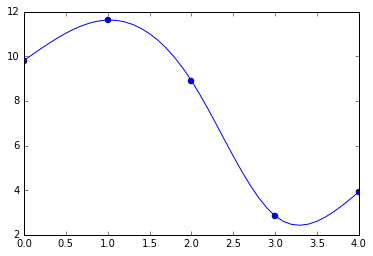

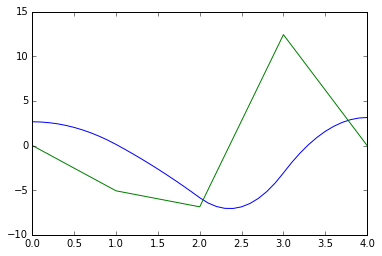

In [3]:
#Plot a different natural spline, along with its 1st and 2nd derivatives, each time you run this
import random
Y = [random.random()*10.0+2 for _ in range(5)]
V = naturalSpline(Y)
xs = [x for x in numpy.arange(0,len(Y)-0.99,0.1)]
plt.figure(0)
plt.plot(xs,[hermite_interp(Y,V,x) for x in xs])
plt.plot(range(0,len(Y)),[Y[x] for x in range(0,len(Y))], "bo")
plt.figure(1)
plt.plot(xs,[hermite_interp1(Y,V,x) for x in xs])
plt.plot(xs,[hermite_interp2(Y,V,x) for x in xs])
